<a href="https://colab.research.google.com/github/kszymon/convnet/blob/main/basics%20/05_nn_implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Implementacja prostej sieci neuronowej

Naszym celem jest wytrenowanie klasyfikatora, który przewiduje przynależność do poprawnej klasy (mężczyzna lub kobieta). Nasze dane nie są liniowo separowalne (nie jesteśmy w stanie narysować lini oddzielającej te zbiory). Liniowe klasyfikatory takie jak Regresja Logistyczna nie będą w stanie dobrze funkcjonować dopóki nie zrobimy ręcznej inżynierii cech wprowadzających liniowość. Z problemem nieliniowości natomiast świetnie radzi sobie sieć neuronowa i jest to jej ogromną zaletą. Nie musimy martwic się inżynierią cech. Warstwy ukryte sieci neuronowych zrobia to za nas!

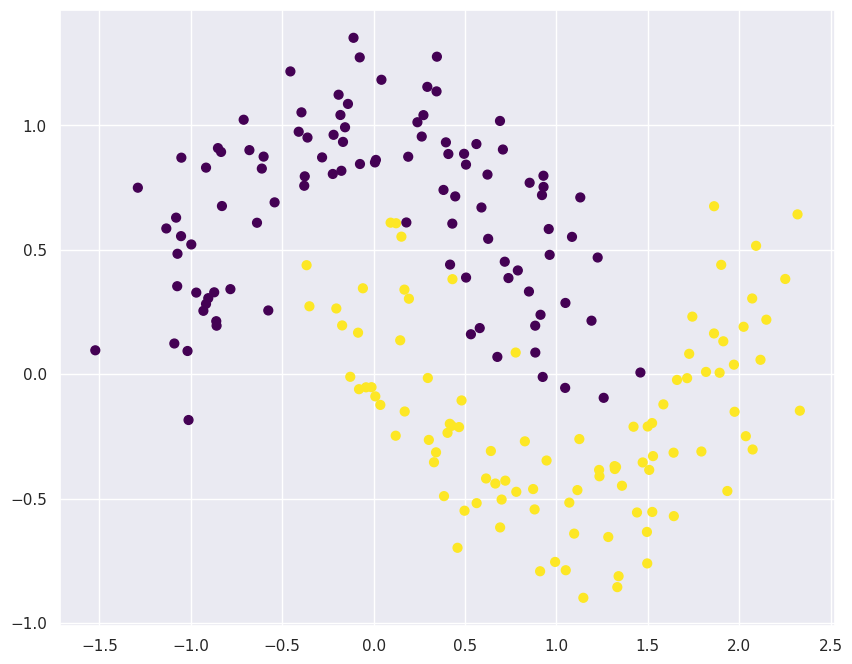

In [74]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
sns.set()

X, y = make_moons(200, noise=0.2)
plt.figure(figsize=(10, 8))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='viridis', s=40)

def plot_decision_boundary(pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral, edgecolors='k')

## Logistic Regression

<Axes: title={'center': 'Logistic Regression'}>

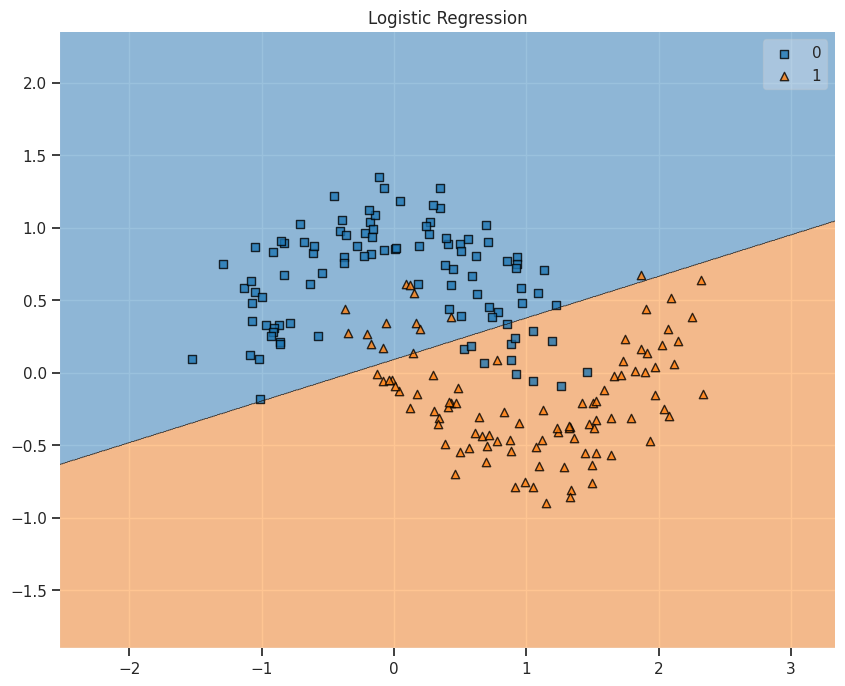

In [75]:
from sklearn.linear_model import LogisticRegression
from mlxtend.plotting import plot_decision_regions

log_reg = LogisticRegression()
log_reg.fit(X, y)

# wykreślenie granicy decyzyjnej
plt.figure(figsize=(10, 8))
plt.title('Logistic Regression')
plot_decision_regions(X, y, log_reg)

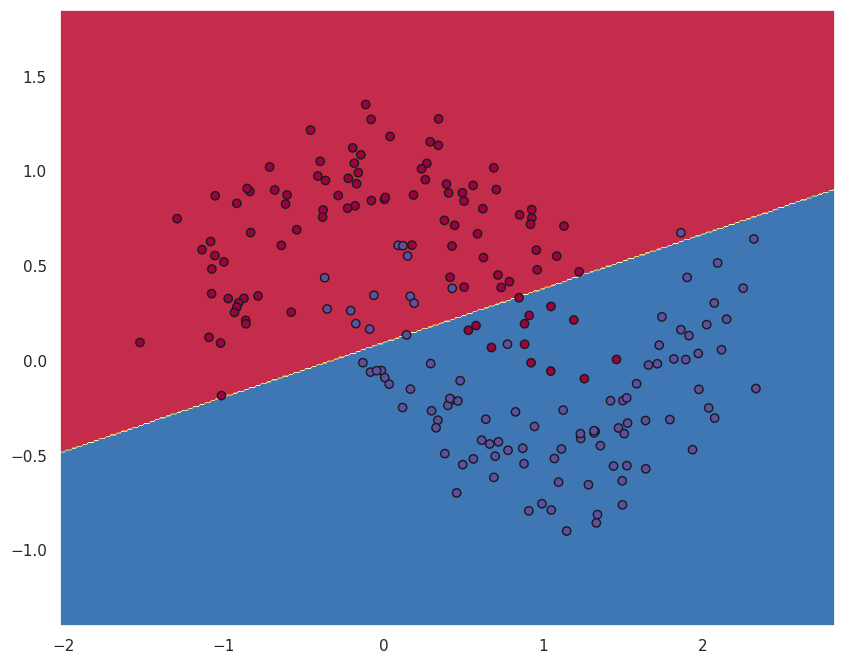

In [76]:
plt.figure(figsize=(10, 8))
plot_decision_boundary(lambda X: log_reg.predict(X))

In [77]:
X.shape, y.shape

((200, 2), (200,))

### Budowa sieci neuronowej

> Zbudujemy 3-warstwową sieć neuronową (warstwa wejścowa, warstwa ukryta, warstwa wyjściowa). Liczba neuronów w warstwie wejściowej jest zdeterminowana przez wymiar naszych danych, podobnie liczba neuronów w warstwie wyjściowej jest zdeterminowana przez liczbę naszych klas.

> Wejściem do sieci będą współrzędne x, y  zaś wyjsciem będzie prawdopodobieństwo przynależności do poszczególnej klasy. Jedne co możemy dowolnie wybrać to rozmiar naszej warstwy ukrytej. Im więcej zastosujemy neuronów w naszej warstwie tym bardziej złożony model bedzie w stanie sie uczyć. Ale nie ma darmowych obiadów! Im większa złożonosc modelu tym więcej potrzebujemy zasobów obliczeniowych i czasu na trenowanie modelu a co gorsza możemy uczynić nasz model skłonnym do przeuczenia (overfitting). Dzieje się tak w sytuacji gdy wytrenowany model dobrze radzi sobie z danymi na których był trenowany i znacznie gorzej na nowych danych, których model jeszcze 'nie widział'.

> Jak dobrać roziar warstwy ukrytej? Zazwyczaj to zależy od specyfiki problemu i bardziej jest to sztuką niż nauką. Można kierować się ogólnymi wytycznymi sugerowanymi przez społeczności wykorzystujące uczenie maszynowe, natomiast nic nie zastapi własnej eksploracji. Podsumowując metoda prób i błędów wydaje się byc tutaj najlepsza.

> Potrzebujemy także dobrać fukncję aktywacji dla naszej warstwy ukrytej. Funkcja aktywacji przekształca inputy na outputy. Nieliniowe funkcje aktywacji pozwalają nam na uczenie sie nieliniowości.
Czestym wyborem dla funkcji aktywacji są:  
* tanh,
* sigmoid,
* ReLU

> My wykorzystamy funkcję `tanh`, która performuje całkiem dobrze w wileu przypadkach. Dobrą własnoscią tej funkcji jest fakt, że pochdna może byc  obliczona przy użyciu orginalnej funkcji, co upraszcza obliczenia. $(tanh\ x)'=1 - tanh^{2}x$
Ponieważ chcemy przewidywać prawdopodobieństwa funkcją aktywacji dla ostatniej warstwy będzie funkcja `softmax`, która jest uogólnieniem funkcji logit na wiele klas.

> Nasza siec bedzie uczyc sie używając propagacji wprzód, która jest tak na prawdę stosem operacji na macierzach. W naszym przypadku mamy:
* Krok 1.  $z_{1} = xW_{1} + b_{1}$
* Krok 2.  $a_{1} = tanh(z_{1}$
* Krok 3.  $z_{2} =  a_{1}W_{2} + b_{2}$
* Krok 4.   $a_{2} = y\_hat = softmax(z_{2})$

$z_{i}$ jest wejsciem do i-tej warstwy zaś $a_{i}$ jest wyjsciem z i-tej warstwy po zastosowaniu funkcji aktywacji.

$W_{1}, W_{2}, b_{1}, b_{2}$ sa parametrami naszej sieci, które chcemy uczyc z danych treningowych.

> Uczenie sieci polega na znalezieniu takich parametrów które minimalizują błąd trenowania. W tym celu definiuje się funkcję straty, którą w naszym przypadku bedzie kategoryczna entropia krzyzowa:
$L(y, y\_hat) = - \frac{1}{N}\sum_{n=1}^{N}\sum_{i\in C}y_{n, i}*log\ y\_hat_{n,i}$ gdzie $N$ to liczba przykładów do trenowania oraz $C$ to klasy, $y$ - rzeczywiste obserwacje, $y\_hat$ - nasze predykcje. W skrócie nasza formuła sumuje po wszystkich naszych przykładach i dodaje wartośc straty, gdy niepoprawnie przewidzieliśmy dana klasę. Stąd otrzymujemy prosta implikację, im bardziej oddalone od siebie będą rozkłady $y$ i $y\_hat$ tym wieksza będzie nasza strata.

> Możemy użyc algorytmu stochastycznego spadku do znalezienia minimum funkcji straty. Jako wejscia algorytm potrzebuje gradinetów (wektor poczodnych) funkcji straty względem naszych parametrów, czyli:
* $\frac{\delta L}{\delta W_{1}}$, $\frac{\delta L}{\delta b_{1}}$
* $\frac{\delta L}{\delta W_{2}}$,  $\frac{\delta L}{\delta b_{2}}$

Aby obliczyć te gradienty wykorzystamy algorytm propagacji wstecznej, który jest efektywnym sposobem liczenia gradientów zaczynając od outputu.

## Implementacja

In [78]:
num_examples = len(X)    # rozmiar zbioru treningowego
nn_input_dim = 2         # wymiar warstwy wejściowej
nn_output_dim = 2        # wymiar warstwy wyjściowej

# parametry do stochastycznego spadku
epsilon = 0.01           # wskaźnik szybkości uczenia
reg_lambda = 0.01        # siła regularyzacji

### Funkcja straty, którą będziemy optymalizować

In [79]:
def calculate_loss(model):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # propagacja wprzód
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # obliczanie straty
    correct_logprobs = -np.log(probs[range(num_examples), y])
    data_loss = np.sum(correct_logprobs)

    data_loss += reg_lambda/2 * (np.sum(np.square(W1)) + np.sum(np.square(W2)))

    return 1./num_examples * data_loss

def predict(model, X):
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']

    # propagacja wprzód
    z1 = X.dot(W1) + b1
    a1 = np.tanh(z1)
    z2 = a1.dot(W2) + b2
    exp_scores = np.exp(z2)
    probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    return np.argmax(probs, axis=1)

def build_model(nn_hdim, num_passes=20000, print_loss=False):
    """
    nn_hdin: liczba neuronów w warstwie ukrytej
    num_passes: liczba przejść przez dane treningowe dla spadku gradientu
    print_loss: jeśli True, printuje stratę co każde 1000 iteracji
    """
    # inicjalizacja parametrów, ktróe bedziemy uczyc
    np.random.seed(0)
    W1 = np.random.randn(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim)
    b1 = np.zeros((1, nn_hdim))
    W2 = np.random.randn(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
    b2 = np.zeros((1, nn_output_dim))

    # to co zwrócimy na koniec zapiszemy do modelu
    model = []

    # spadek stochastyczny
    for i in range(0, num_passes):

        # propagacja wprzód
        z1 = X.dot(W1) + b1
        a1 = np.tanh(z1)
        z2 = a1.dot(W2) + b2
        exp_scores = np.exp(z2)
        probs = exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

        # propagacja wsteczna
        delta3 = probs
        delta3[range(num_examples), y] -= 1
        dW2 = (a1.T).dot(delta3)
        db2 = np.sum(delta3, axis=0, keepdims=True)
        delta2 = delta3.dot(W2.T) * (1 - np.power(a1, 2))
        dW1 = np.dot(X.T, delta2)
        db1 = np.sum(delta2, axis=0)

        # aktualizacja parametrów uczenia
        W1 += -epsilon * dW1
        b1 += -epsilon * db1
        W2 += -epsilon * dW2
        b2 += -epsilon * db2

        # przypisanie nowych parametrów do modelu
        model = { 'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2}

        if print_loss and i % 1000 == 0:
            print('Strata po iteracji {} wynosi {}'.format(i, calculate_loss(model)))

    return model

In [80]:
model = build_model(3, print_loss=True)

Strata po iteracji 0 wynosi 0.4169236975521983
Strata po iteracji 1000 wynosi 0.06437525917853376
Strata po iteracji 2000 wynosi 0.06261387640088562
Strata po iteracji 3000 wynosi 0.05530236684369828
Strata po iteracji 4000 wynosi 0.05538757859089663
Strata po iteracji 5000 wynosi 0.05819978033069141
Strata po iteracji 6000 wynosi 0.05668427869784434
Strata po iteracji 7000 wynosi 0.05571919984127068
Strata po iteracji 8000 wynosi 0.05580661151056757
Strata po iteracji 9000 wynosi 0.06892624559673094
Strata po iteracji 10000 wynosi 0.05558307428394243
Strata po iteracji 11000 wynosi 0.05610904617022091
Strata po iteracji 12000 wynosi 0.18928124578340366
Strata po iteracji 13000 wynosi 0.056176825910090725
Strata po iteracji 14000 wynosi 0.10041584817194851
Strata po iteracji 15000 wynosi 0.056509077295829366
Strata po iteracji 16000 wynosi 0.05612892530299936
Strata po iteracji 17000 wynosi 0.0607619240357855
Strata po iteracji 18000 wynosi 0.05672069523085094
Strata po iteracji 19000 

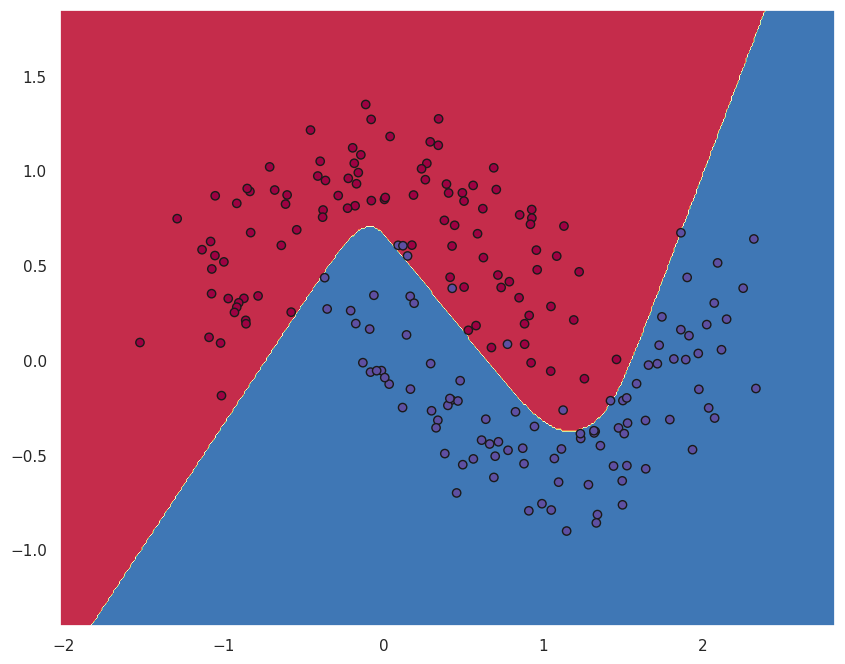

In [81]:
plt.figure(figsize=(10, 8))
plot_decision_boundary(lambda X: predict(model, X))

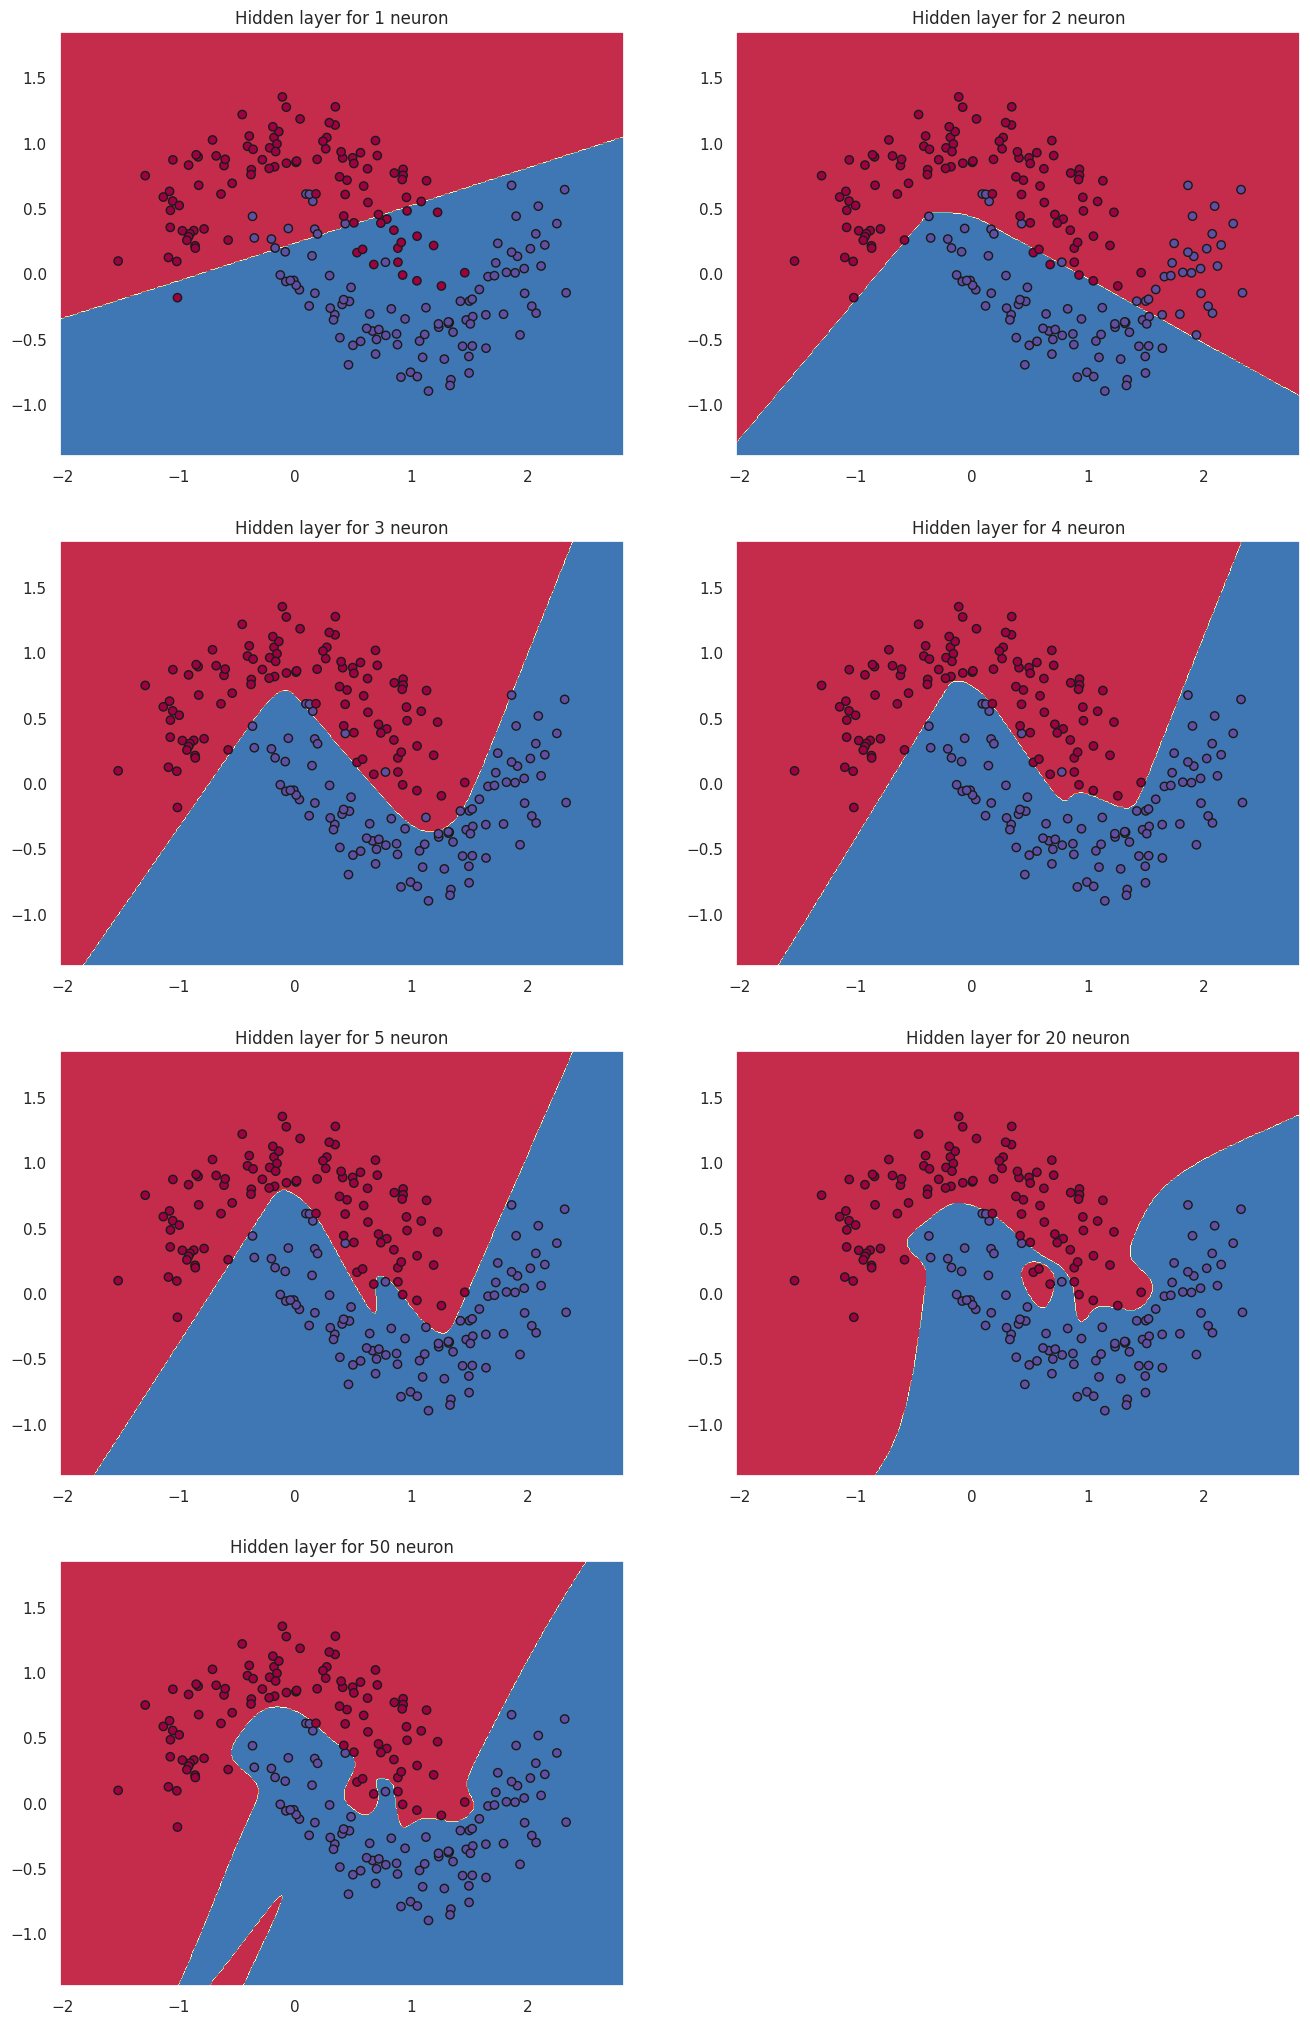

In [82]:
plt.figure(figsize=(16, 32))
hidden_layer_dimensions = [1, 2, 3, 4, 5, 20, 50]
for i, nn_hdim in enumerate(hidden_layer_dimensions):
    plt.subplot(5, 2, i+1)
    plt.title('Hidden layer for {} neuron'.format(nn_hdim))
    model = build_model(nn_hdim)
    plot_decision_boundary(lambda X: predict(model, X))
plt.show()

Jak się okazało, warstwy ukryte z niewielką ilością neuronów sa w stanie bardzo dobrze generalizować nasze dane, przy większej ilości neuronów sieci są bardziej skłonne do przeuczenia. Gdybyśmy przetestowali na nowych danych nasz model zbyt dopasowany model performowałby gorzej niż ten z mnijeszą warstwą neuronów, a przecież nie o to nam chodzi.